## Topics Covered

- returns, volatility
- annualized returns, annualized volatility
- Sharpe Ratio: Risk-adjusted measure of returns
- Max Drawdown: Worst-case scenario. "Buy at peak and sell at trough" 

- Risk Measures: 
    - VaR, CVaR 
    - Semi-Deviation

## Dataset
- The dataset we're working with contains returns from various partitions of the S&P 500. We use the 'Lo 10' and 'Hi 10' for this week, which is the lowest decile and highest decile of stocks by market capitalization. 

In [199]:
import pandas as pd
import numpy as np

# Each column refers to a set of companies, and an equal weighting within each category
returns = pd.read_csv("data/Portfolios_Formed_on_ME_monthly_EW.csv", 
                      index_col=0,
                      na_values=-99.99)

# Let's extract the returns from just the lower decile of market cap and upper decile of market cap
cols = ['Lo 10', 'Hi 10']
returns = returns[cols]/100
returns = returns.rename({"Lo 10": "Small Cap", "Hi 10": "Large Cap"}, axis=1)
returns.index = pd.to_datetime(returns.index, format='%Y%m')
returns.index = returns.index.to_period('M')


### Functions for annualizing returns and volatility

In [200]:
def annualized_vol(returns, period='month'):
    
    # check that returns is a dataframe of returns
    assert type(returns) == pd.DataFrame
    
    if period == 'month':
        p = 12
    elif period == 'day':
        p = 252
        
    # annualize volatility by computing period based vol, and multiplying by sqrt(p)
    ann_vol = returns.std()*np.sqrt(p)
    return ann_vol

def annualized_return(returns, period='month'):
    
    # check that returns is a dataframe of returns
    assert type(returns) == pd.DataFrame
    
    if period == 'month':
        p = 12
        
    if period == 'day':
        p = 252
    
    num_periods = returns.shape[0]
    
    # this generates the total compounded return for all months
    total_return = (1 + returns).prod()
    
    # raise the total return to (1/num_periods) to get a period return
    period_return = total_return ** (1/num_periods)
    
    # find the annual return
    annual_return = period_return ** p - 1
    
    return annual_return

### Sharpe Ratio

In [201]:
def sharpe_ratio(returns, rf, ann_ret=None, ann_vol=None):
    
    if (ann_ret==None and ann_vol==None):
        ann_vol = annualized_vol(returns)
        ann_ret = annualized_return(returns)
                
    sharpe = (ann_ret - rf)/ann_vol
    return sharpe

In [202]:
# compute the sharpe ratio
ann_vol = annualized_vol(returns)
ann_ret = annualized_return(returns)
sharpe = sharpe_ratio(returns, rf=0.03)
print(sharpe)

Small Cap    0.373346
Large Cap    0.336392
dtype: float64


### Max Drawdown

In [204]:
def get_wealth_index(returns, plot=False):
    
    assert type(returns) == pd.Series
    wealth_index = (1 + returns).cumprod()
    prev_max = wealth_index.cummax()
    df_wealth = pd.DataFrame({"wealth": wealth_index, "peaks":prev_max})
    
    if plot:
        df_wealth.plot.line()
        
    return df_wealth

def compute_drawdown(returns, plot=False):
    
    assert type(returns) == pd.Series
    df_wealth = get_wealth_index(returns)
    drawdown = (df_wealth["wealth"] - df_wealth["peaks"])/df_wealth["peaks"]
    
    if plot:
        drawdown.plot.line()
        
    return drawdown

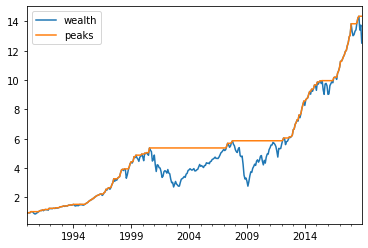

In [205]:
returns_lc = returns["Large Cap"]
df_wealth = get_wealth_index(returns_lc["1990":], plot=True)

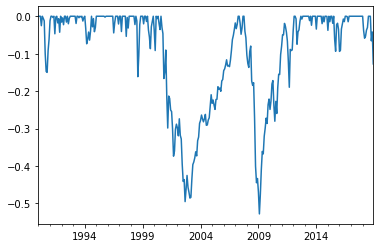

In [206]:
drawdown = compute_drawdown(returns_lc["1990":], plot=True)

## Topics Covered

- Downside Risk Measures: 
    - VaR, CVaR 
    - Semi-Deviation
    
## Dataset
- this dataset generates the returns of various hedge fund strategies

In [212]:
hfi = pd.read_csv("data/edhec-hedgefundindices.csv",
                  header=0,
                  index_col=0,
                  parse_dates=True)

hfi.index = hfi.index.to_period("M")
hfi = hfi/100

In [245]:
import scipy.stats as stats

def skewness(series):
    assert type(series) == pd.Series
    return stats.skew(series)

def kurtosis(series):
    assert type(series) == pd.Series
    # kurtosis subtracts 3 by default
    return stats.kurtosis(series) + 3

def semi_deviation(df):
    assert type(df) == pd.DataFrame
    semi_dev = df[df < df.mean()].std(ddof=0)
    return semi_dev
    

<AxesSubplot:>

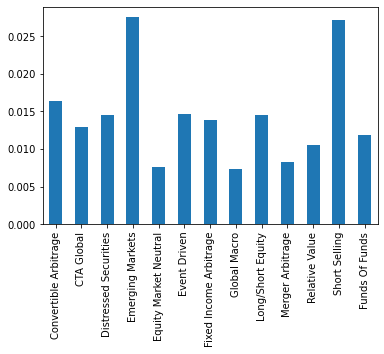

In [275]:
semi_dev = semi_deviation(hfi)
semi_dev.plot.bar()

In [290]:
# alpha is the significance level
def corner_fish_VaR(series, alpha):
    
    assert type(series) == pd.Series
    z_norm = stats.norm.ppf(alpha)
    skew = skewness(series)
    kurt = kurtosis(series)

    # get the z-score using the Corner-Fisher adjustment
    z_cf = z_norm + \
           (z_norm**2 - 1)*(skew/6) + \
           (z_norm**3 - 3*z_norm)*(kurt - 3)/24 - \
           (2*z_norm**3 - 5*z_norm)*(skew**2)/36

    # compute the VaR
    VaR = -(series.mean() + z_cf*series.std(ddof=0))
    return VaR
  

<AxesSubplot:>

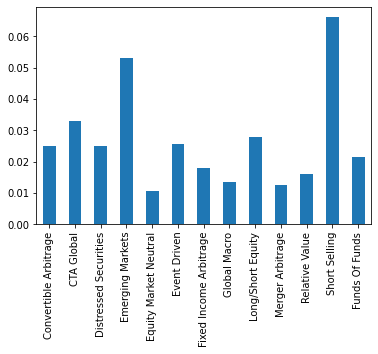

In [291]:
cf_VaR = hfi.aggregate(corner_fish_VaR, alpha=0.05)
cf_VaR.plot.bar()

In [300]:
def compute_CVaR(series, alpha):
    assert type(series) == pd.Series
    VaR = corner_fish_VaR(series, alpha)
    CVaR = -series[series < -VaR].mean()
    return CVaR

<AxesSubplot:>

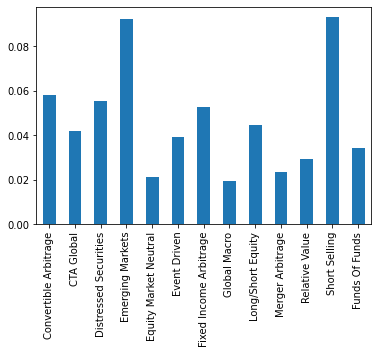

In [305]:
CVaR = hfi.aggregate(compute_CVaR, alpha=0.05)
CVaR.plot.bar()